# **Introduction:** 

This file serves to host the downstream integration of our project for TME 6015: AI/ML Workflow Design. The integration that was used pertains to a simulated task allocation scenario within a warehouse environment. Tasks within the warehouse can have three different load requirements: *Small*, *Medium*, or *Large*, and robots can have a similar load capacity denoted by *Small*, *Medium*, or *Large*.

Robots are also defined by their distance to the task, their load history, and their travel history. The goal is therefore to:

* Allocate a robot with a matching capability to the task requirement;
* Prioritize robots with a low load history;
* Prioritize robots that are closer to the task;
* Prioritize robots that have not travelled far at the time of allocation, and;
* To accomplish the aforementioned goals using our ANN architecture. 

**Date Created: 25/11/2024**

**Date Modified: 25/11/2024**

# **Import Packages:**

Need to import the following packages for this simulation:

In [288]:
# import packages:

import numpy as np
import matplotlib.pyplot as plt
import math as m
import heapq
import cv2
import os
import time
import pandas as pd
from PythonFISFunction import *
from IPython.display import clear_output

import tensorflow as tf                                 
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from keras.metrics import MeanSquaredError


# **Define Classes & Functions:**

Need to define the following classes and functions for this simulation:

In [289]:
# define robot class:

class Robot:
    # constructor:
    def __init__(self, id, capability, position, colour):   
        self.id = id                      # identifier tag for each robot
        self.capability = capability      # carrying capacity of the robot
        self.position = position          # position in space of robot
        self.colour = colour              # colour identifier
        self.initial_position = position  # initial position used when switching between FIS and ANN

        self.load_history = 0.0           # load history of the robot
        self.distance_to_task = 0.0       # planned travel distance of robot
        self.travel_history = 0.0         # travel history of the robot
        self.cap_match = 0.0              # binary capability matching of each robot
        
        self.suitability = 0.0            # suitability of robot
        
class Task:
    # constructor:
    def __init__(self, position, requirement, colour):
        self.position = position
        self.requirement = requirement
        self.colour = colour

def dijkstra(image, start, goal):

    # first need to get the dimensionality of the image:
    rows, cols = image.shape

    # swap the (x, y) input to (y, x) format for internal use - cv2 has y,x notation
    start = (start[1], start[0])  # swap (x, y) -> (y, x)
    goal = (goal[1], goal[0])     # swap (x, y) -> (y, x)

    # need to initialize both the distance map and the previous node map:
    dist = np.full((rows,cols), np.inf)  # set other distances to a very big number
    dist[start] = 0                      # set the initial starting distance to 0

    # need to track the parent of each node such that the resulting path can be reconstructed:
    parent = {start: None}

    # start the priority queue to store the distance values in x and y:
    pq = [(0, start)]

    # encode the directions that the robot can move, assuming 8 options of movement at each given
    # node, 45 degree offsets (holonomic movement):
    directions = [
        (-1,0), (1,0), (0,-1), (0,1),    # left, right, down, up
        (-1,-1), (-1,1), (1,-1), (1,1)   # diagonals
    ]

    # define a set for the visited node:
    visited = set()

    while pq:
        current_dist, (x, y) = heapq.heappop(pq)
        
        # if the node has already been visited, skip it
        if (x, y) in visited:
            continue
        visited.add((x, y))
        
        # if we reached the goal, reconstruct the path:
        if (x, y) == goal:
            path = []
            while (x,y) != start:
                path.append((y,x))
                x,y = parent[(x,y)]
            path.append((start[1],start[0]))
            return path[::-1], dist[goal] # reverse path 
        
    # explore neighbors
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols and (nx, ny) not in visited:
                # ignore black borders
                if image[nx, ny] >= 254:  # threshold for white space
                    # calculate the movement cost
                    movement_cost = m.sqrt(2) if dx != 0 and dy != 0 else 1
                    new_dist = current_dist + movement_cost
                    
                    # if a shorter path is found, update the distance and push to pq
                    if new_dist < dist[nx, ny]:
                        dist[nx, ny] = new_dist
                        parent[(nx,ny)] = (x,y)
                        heapq.heappush(pq, (new_dist, (nx, ny)))
    
    return None, None # if goal unreachable

def add_buffer(image, buffer_size):

    # create a binary mask where black (0) and gray (205) areas are marked
    mask = np.where((image == 0) | (image == 205), 1, 0).astype(np.uint8)
    
    # create a kernel for dilation (buffer expansion)
    kernel = np.ones((buffer_size, buffer_size), np.uint8)
    
    # dilate the mask (expand obstacles)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    
    # create a new image where dilated areas are treated as non-navigable (set to black)
    buffered_image = image.copy()
    buffered_image[dilated_mask == 1] = 0  # set dilated areas to black (0)

    # white space detection:
    _, thresh = cv2.threshold(buffered_image, 254, 255, cv2.THRESH_BINARY)

    # Find coordinates of white pixels
    white_pixels = cv2.findNonZero(thresh)
    
    return buffered_image, white_pixels

def draw_on_image(image, task):
    # draw star for tasks:
    points = []
    num_points = 5
    outer_radius = 5
    inner_radius = 2
    
    angle = np.pi / num_points

    for i in range(num_points * 2):  # For outer and inner points
        radius = outer_radius if i % 2 == 0 else inner_radius  # Alternate between outer and inner radius
        x = int(task.position[0] + radius * np.cos(i * angle))  # X coordinate
        y = int(task.position[1] - radius * np.sin(i * angle))  # Y coordinate
        points.append((x, y))
    
    # Convert points to numpy array
    points = np.array(points, np.int32)
    
    # Reshape points for polylines
    points = points.reshape((-1, 1, 2))
    
    # Draw the star using polylines
    cv2.polylines(image, [points], isClosed=True, color = task.colour, thickness=2)

    # draw circle for robots:
    for robot in robots.values():
        position = robot.position
        cv2.circle(image, position, 3 , robot.colour, -1)

    return image

# **Initializing the Simulation:**

Need to first load the map and determine the white space where robots can be spawned:

In [290]:
# get the map string:
files_in_dir = os.listdir(os.getcwd())
file_path = os.path.join(os.getcwd(), files_in_dir[files_in_dir.index('warehouse_map.png')])

# load the image:
image = cv2.imread(file_path,0)
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# apply dilation to get navigable space assuming 30 cm (6 pixel x 5cm/pixel) tolerance:
buffered_image, spawn_locations = add_buffer(image, 6)

Set the parameters for the simulation. This defines the total number of robots, and the number of each load capacity to include:

In [291]:
# reshape spawn locations:
spawn_locations = spawn_locations.reshape(-1, 2)

# define simulation parameters:
nr = 6      # number of robots overall
x = 2       # nunber of "small" robots
y = 2       # number of "medium" robots
z = 2       # number of "large" robots

nt = 25             # number of tasks to be spawned

robots = {}               # empty dictionary to hold robots
tasks = {}                # empty dictionary to hold tasks
fis_allocations = []      # list for FIS allocations
ann_allocations = []      # list for ANN allocations

rulebase = fis_create()   # initialize rulebase for the FIS
loaded_model = load_model('model.h5', custom_objects={'mse': metrics.MeanSquaredError()})

c:\Users\mtidd2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\mtidd2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Spawn robots based on parameters:

In [292]:
# spawn robots:
for num in range(1, nr+1):
    robot_name = f"Robot {num}"
    
    # if we haven't exceeded the number of "small" robots:
    if num <= x:
        index = np.random.choice(spawn_locations.shape[0])
        robots[robot_name] = Robot(
            id = num,
            capability = 'Small',
            position = spawn_locations[index],
            colour = (0,255,0)
        )
        spawn_locations = np.delete(spawn_locations, index, axis = 0)
    
    # if we haven't exceeded the number of "medium" robots:
    elif num  <= y+x:
        index = np.random.choice(spawn_locations.shape[0])
        robots[robot_name] = Robot(
            id = num,
            capability = 'Medium',
            position = spawn_locations[index],
            colour = (0,0,255)
        )
        spawn_locations = np.delete(spawn_locations, index, axis = 0)

    # if we haven't exceeded the number of "large" robots:
    else:
        index = np.random.choice(spawn_locations.shape[0])
        robots[robot_name] = Robot(
            id = num,
            capability = 'Large',
            position = spawn_locations[index],
            colour = (255,165,0)
        )
        spawn_locations = np.delete(spawn_locations, index, axis = 0)

Generate as many tasks as the user specifies:

In [293]:
# spawn tasks:
for i in range(1, nt+1):

    task_name = f"Task {i}"

    # assign task object a random position within space:
    index = np.random.choice(spawn_locations.shape[0])
    task_position = spawn_locations[index]
    spawn_locations = np.delete(spawn_locations, index, axis = 0)

    # assign task object a random requirement:
    task_requirement = np.random.choice(['Small', 'Medium', 'Large'])

    # make task red:
    task_colour = (255,0,0)

    # create task object
    task = Task(task_position, task_requirement, task_colour)

    # add to dictionary
    tasks[task_name] = task


# **Simulation - FIS:**

Can now simulate task allocation using the FIS. This is done by first iterating through each task and having each robot calculate their suitability. The robot with the highest suitability goes to the task site, and has their parameters updated accordingly.

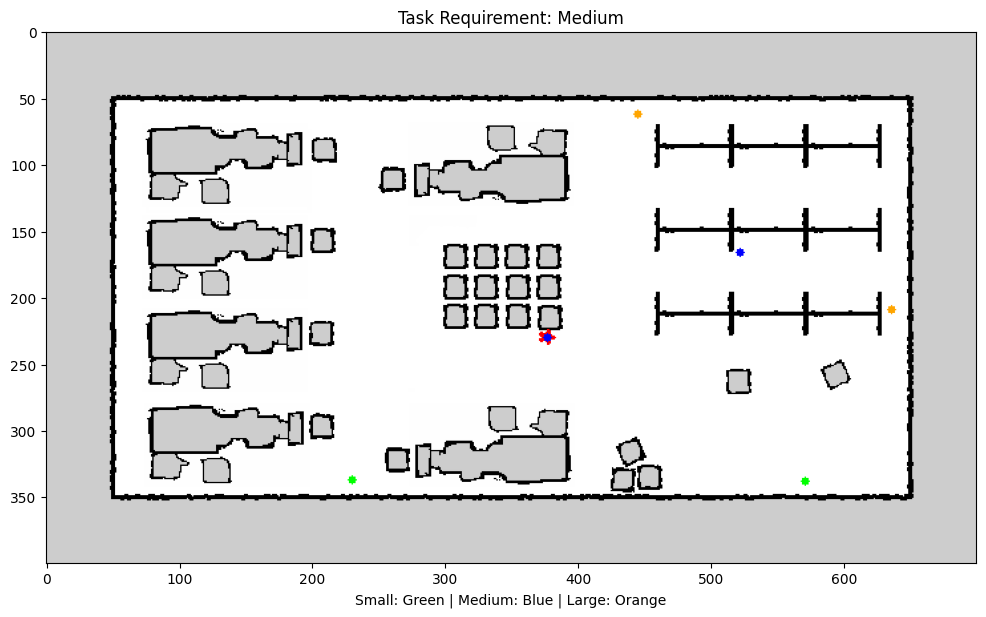

In [294]:
# allocation simulation - FIS:

fig = plt.figure(figsize = (12,10))

for task in tasks.values():

    # initial plot to view positions:
    combined_image = draw_on_image(image_rgb.copy(), task)

    clear_output(wait=True)
    fig = plt.figure(figsize = (12,10))
    plt.imshow(combined_image)
    plt.title(f'Task Requirement: {task.requirement}')
    plt.xlabel(f'Small: Green | Medium: Blue | Large: Orange')
    plt.pause(0.5)

    start_time = time.time()
    for id, robot in robots.items():

        # get robot position:
        start = robot.position

        # determine length of planned path:
        shortest_path, dist = dijkstra(buffered_image, start, task.position)

        # add the shortest path if it exists:
        if shortest_path is not None:
            for x,y in shortest_path:
                combined_image[y,x] = robot.colour

        # update the robots planned travel distance:
        robot.distance_to_task = round((dist*0.05), 3)

        # need to get capability match:
        robot.cap_match = 1 if task.requirement == robot.capability else 0

        # use FIS to get suitability:
        robot.suitability = round(fis_solve(rulebase, robot.load_history, robot.distance_to_task, robot.travel_history, robot.cap_match), 2)

    elapsed = time.time() - start_time

    # get ID of highest suitability robot:
    best_robot_id = max(robots, key=lambda robot_id: robots[robot_id].suitability)
    
    # draw with planned path:
    clear_output(wait=True)
    fig = plt.figure(figsize = (12,10))
    plt.imshow(combined_image)
    plt.title(f'Task Requirement: {task.requirement}')
    plt.xlabel(f'Small: Green | Medium: Blue | Large: Orange')
    plt.pause(0.5)

    # best robot goes to task site, update their parameters accordingly:
    best_robot = robots[best_robot_id]
    best_robot.load_history += 1
    best_robot.position = task.position
    best_robot.travel_history = robot.distance_to_task

    fis_allocations.append((f"Robot {best_robot.id}", round(elapsed,2), float(best_robot.suitability)))

    # draw after allocation:
    combined_image = draw_on_image(image_rgb.copy(),task)

    clear_output(wait=True)
    fig = plt.figure(figsize = (12,10))
    
    plt.imshow(combined_image)
    plt.title(f'Task Requirement: {task.requirement}')
    plt.xlabel(f'Small: Green | Medium: Blue | Large: Orange')
    plt.pause(0.5)
    

# **Simulation - ANN:**

Need to first reset the robots:

In [295]:
# reset the robots used:
for robot in robots.values():
    robot.load_history = 0.0
    robot.distance_to_task = 0.0
    robot.travel_history = 0.0
    robot.cap_match = 0.0
    robot.suitability = 0.0

    robot.position = robot.initial_position

ANN simulation:

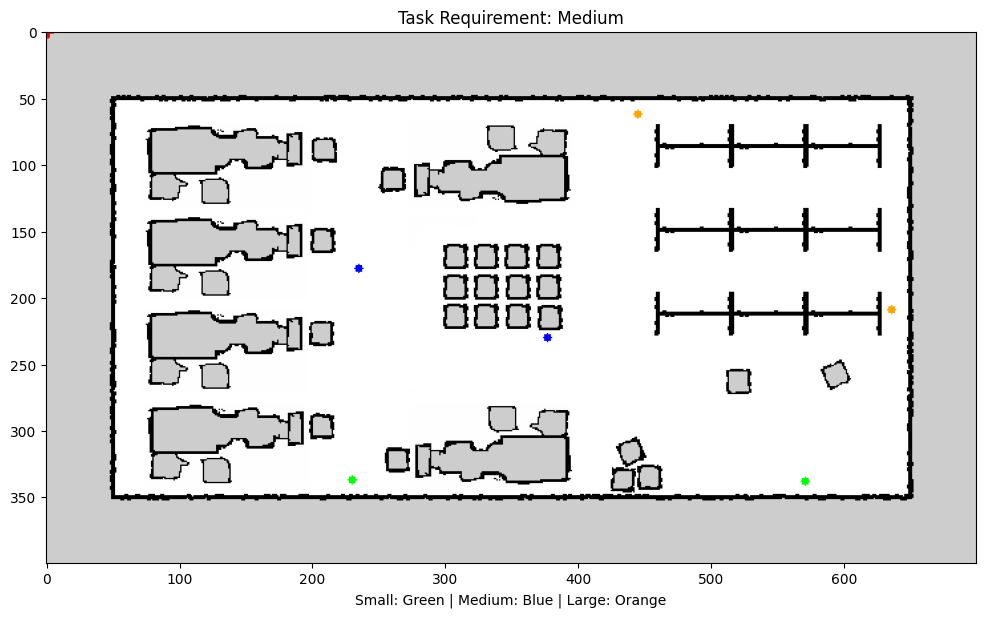

In [296]:
# allocation simulation - FIS:

fig = plt.figure(figsize = (12,10))

for task in tasks.values():

    # initial plot to view positions:
    combined_image = draw_on_image(image_rgb.copy(), task)

    clear_output(wait=True)
    fig = plt.figure(figsize = (12,10))
    plt.imshow(combined_image)
    plt.title(f'Task Requirement: {task.requirement}')
    plt.xlabel(f'Small: Green | Medium: Blue | Large: Orange')
    plt.pause(0.5)

    start_time = time.time()
    for id, robot in robots.items():

        # get robot position:
        start = robot.position

        # determine length of planned path:
        shortest_path, dist = dijkstra(buffered_image, start, task.position)

        # add the shortest path if it exists:
        if shortest_path is not None:
            for x,y in shortest_path:
                combined_image[y,x] = robot.colour

        # update the robots planned travel distance:
        robot.distance_to_task = round((dist*0.05), 3)

        # need to get capability match:
        robot.cap_match = 1 if task.requirement == robot.capability else 0

        # form input vector for ANN:

        input = np.array([robot.load_history, robot.distance_to_task, robot.travel_history, robot.cap_match]).reshape(1, 4)

        # use ANN to get suitability:

        robot.suitability = loaded_model.predict(input)

    elapsed = time.time() - start_time

    # get ID of highest suitability robot:
    best_robot_id = max(robots, key=lambda robot_id: robots[robot_id].suitability)
    
    # draw with planned path:
    clear_output(wait=True)
    fig = plt.figure(figsize = (12,10))
    plt.imshow(combined_image)
    plt.title(f'Task Requirement: {task.requirement}')
    plt.xlabel(f'Small: Green | Medium: Blue | Large: Orange')
    plt.pause(0.5)

    # best robot goes to task site, update their parameters accordingly:
    best_robot = robots[best_robot_id]
    best_robot.load_history += 1
    best_robot.position = task.position
    best_robot.travel_history = robot.distance_to_task

    ann_allocations.append((f"Robot {best_robot.id}", round(elapsed,2), round(float(best_robot.suitability),2)))

    # draw after allocation:
    task.position = (0,0)
    combined_image = draw_on_image(image_rgb.copy(),task)

    clear_output(wait=True)
    fig = plt.figure(figsize = (12,10))
    plt.imshow(combined_image)
    plt.title(f'Task Requirement: {task.requirement}')
    plt.xlabel(f'Small: Green | Medium: Blue | Large: Orange')
    plt.pause(0.5)


# **Comparing Results:**

With both simulations complete, need to now compare between both models. Performance is quantified in terms of their ability to produce the same results, and the time of inference for the entire MRS.

In [297]:
# turn values to pandas dataframe:

ANN_results = pd.DataFrame(ann_allocations, columns = ['Winning Robot', 'Inference Time', 'Suitability'])
FIS_results = pd.DataFrame(fis_allocations, columns = ['Winning Robot', 'Inference Time', 'Suitability'])

ANN_results.tail()

,Winning Robot,Inference Time,Suitability
20,Robot 5,1.94,5.97
21,Robot 3,1.48,7.08
22,Robot 1,1.61,4.75
23,Robot 1,2.17,5.04
24,Robot 3,1.14,6.31


In [298]:
FIS_results.tail()

,Winning Robot,Inference Time,Suitability
20,Robot 5,2.36,5.92
21,Robot 3,2.11,7.12
22,Robot 1,1.82,4.88
23,Robot 1,2.61,5.00
24,Robot 4,1.84,6.59


Save dataframes as CSV:

In [299]:
ANN_results.to_csv('results/ANN_results.csv')
FIS_results.to_csv('results/FIS_results.csv')

Compare between the two:

accuracy of ANN is: 0.96

mean FIS inference time: 2.218 
 mean ANN inference time: 1.726

mean FIS suitability: 6.382 
 mean ANN suitability: 6.351


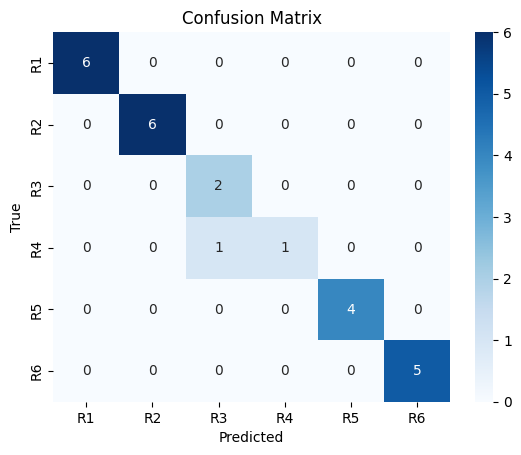

In [300]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# get labels from both:
FIS_labels = FIS_results['Winning Robot']
ANN_labels = ANN_results['Winning Robot']

# accuracy:
accuracy = accuracy_score(ANN_labels,FIS_labels)
print(f"accuracy of ANN is: {accuracy}\n")

# get average time:
mean_time_FIS = FIS_results['Inference Time'].mean()
mean_time_ANN = ANN_results['Inference Time'].mean()

# get average suitability:

mean_suit_FIS = FIS_results['Suitability'].mean()
mean_suit_ANN = ANN_results['Suitability'].mean()

print(f"mean FIS inference time: {round(mean_time_FIS,3)} \n mean ANN inference time: {round(mean_time_ANN,3)}\n")
print(f"mean FIS suitability: {round(mean_suit_FIS,3)} \n mean ANN suitability: {round(mean_suit_ANN,3)}")

# confusion matrix:
cm = confusion_matrix(FIS_labels, ANN_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = ('R1','R2','R3','R4','R5','R6'), yticklabels = ('R1','R2','R3','R4','R5','R6'))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
